##### <div style="color:lightblue;background-color:darkred;padding:3%;border-radius:150px 150px;font-size:2em;text-align:center">SALES PREDICTION</div>

## <a id="100" style="color:darkred">Importing packages :</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Sales-Prediction.csv")

In [3]:
df.head(10)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
5,6,8.7,48.9,75.0,7.2
6,7,57.5,32.8,23.5,11.8
7,8,120.2,19.6,11.6,13.2
8,9,8.6,2.1,1.0,4.8
9,10,199.8,2.6,21.2,10.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [5]:
df.describe(include="all")

,Unnamed: 0,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [6]:
df.isnull().sum()

Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64

In [7]:
df.shape

(200, 5)

## <a id="61" style="color: darkred;"> Exploratory Data Analysis (EDA): </a>

In [8]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    # sum['value_counts']=train.value_counts()
    # sum['skew'] = train.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
Unnamed: 0,int64,0,0.000000,200,200,1.000000,200.000000,100.500000
TV,float64,0,0.000000,190,200,0.700000,296.400000,147.042500
Radio,float64,0,0.000000,167,200,0.000000,49.600000,23.264000
Newspaper,float64,0,0.000000,172,200,0.300000,114.000000,30.554000
Sales,float64,0,0.000000,121,200,1.600000,27.000000,14.022500


In [9]:
df.duplicated().sum()

0

In [10]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [11]:
df.columns

Index(['TV', 'Radio', 'Newspaper', 'Sales'], dtype='object')

## <a id="61" style="color: darkred;"> Data Visualization: </a>

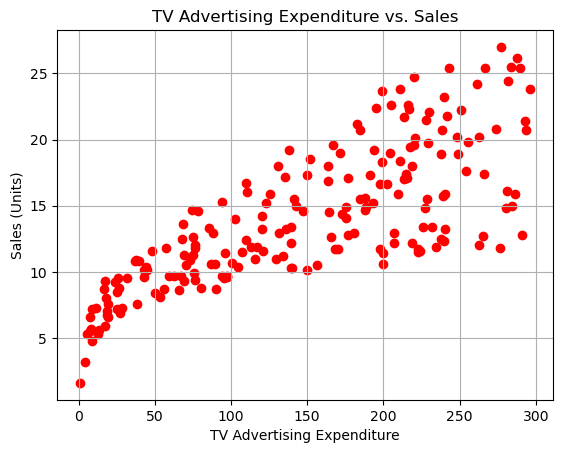

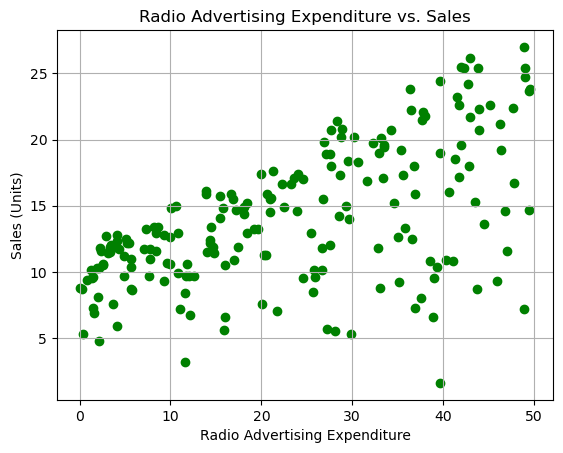

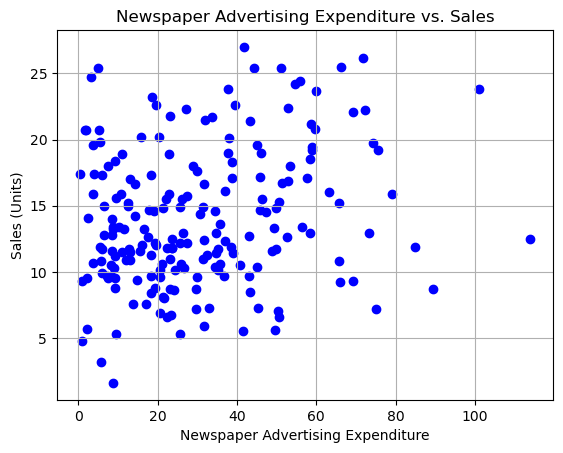

In [12]:
colors = ['red', 'green', 'blue', 'purple']  # Add more colors if needed
for i, col in enumerate(df.columns[:-1]):
    plt.scatter(df[col], df['Sales'], color=colors[i])
    plt.xlabel(f'{col} Advertising Expenditure')
    plt.ylabel('Sales (Units)')
    plt.title(f'{col} Advertising Expenditure vs. Sales')
    plt.grid(True)
    plt.show()

<Figure size 700x300 with 0 Axes>

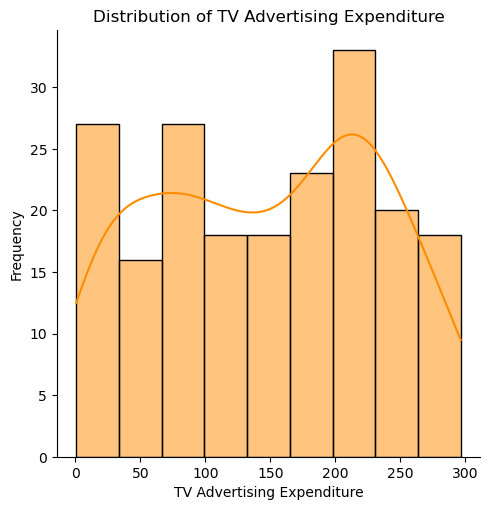

In [13]:
plt.figure(figsize=(7, 3))
sns.displot(df['TV'], kde=True, color='darkorange')  # You can adjust the color as needed
plt.xlabel('TV Advertising Expenditure')
plt.ylabel('Frequency')
plt.title('Distribution of TV Advertising Expenditure')
plt.show()

<Figure size 700x300 with 0 Axes>

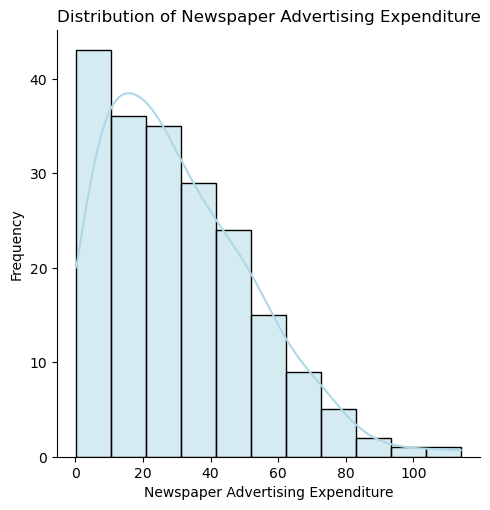

In [14]:
plt.figure(figsize=(7, 3))
sns.displot(df['Newspaper'], kde=True, color='lightblue')
plt.xlabel('Newspaper Advertising Expenditure')
plt.ylabel('Frequency')
plt.title('Distribution of Newspaper Advertising Expenditure')
plt.show()

<Figure size 700x300 with 0 Axes>

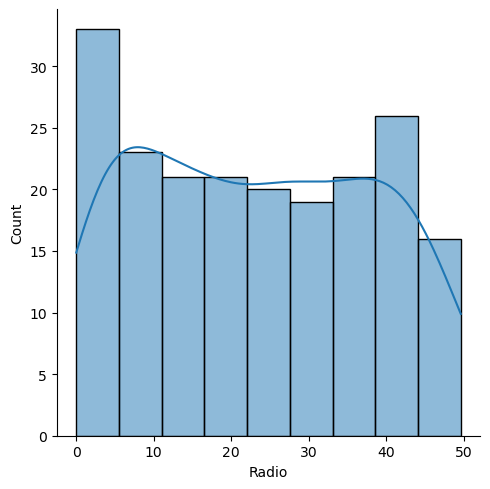

In [15]:
plt.figure(figsize=(7,3))
sns.displot(df['Radio'],kde=True)

<Figure size 700x300 with 0 Axes>

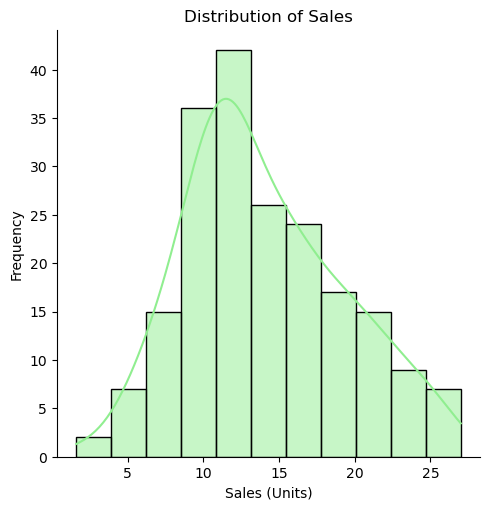

In [16]:
plt.figure(figsize=(7, 3))
sns.displot(df['Sales'], kde=True, color='lightgreen')
plt.xlabel('Sales (Units)')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.show()

<Axes: >

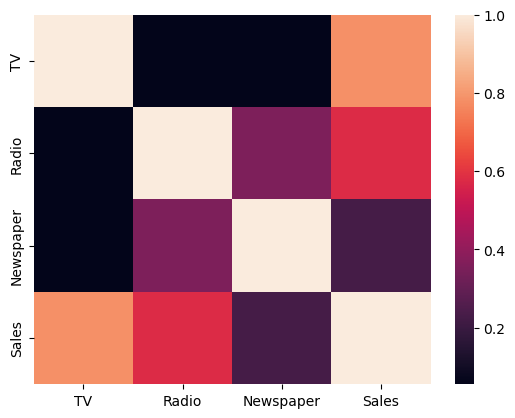

In [17]:
sns.heatmap(df.corr())

### <a id="61" style="color: darkred;"> Handling Outliers : </a>

<Axes: >

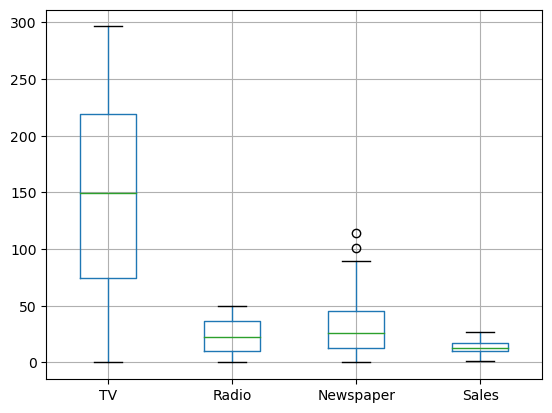

In [18]:
df.boxplot()

In [19]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage
numeric_columns = df.select_dtypes(include=['number']).columns
columns_with_outliers = [detect_outliers(column) for column in numeric_columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: Newspaper, Percentage of outliers: 1.00%


In [20]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    return lower_range,upper_range

In [21]:
low_leadtime,high_leadtime=remove_outlier(df['Newspaper'])
df['Newspaper']=np.where(df['Newspaper']>high_leadtime,high_leadtime,df['Newspaper'])
df['Newspaper']=np.where(df['Newspaper']<low_leadtime,low_leadtime,df['Newspaper'])

In [22]:
x=df.drop(['Sales'],axis=1)
y=df['Sales']

In [23]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=142)

In [24]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(160, 3)
(40, 3)
(160,)
(40,)


### <a id="61" style="color: darkred;">StandardScaler: </a>

In [25]:
scalar=StandardScaler()
scalar.fit(xtrain)
xtrain_sc=scalar.transform(xtrain)
xtest_sc=scalar.transform(xtest)

## <a id="61" style="color: darkred;"> Model Building: </a>

### <a id="61" style="color: blue;"> LinearRegression: </a>

In [26]:
lr=LinearRegression()
lr.fit(xtrain_sc,ytrain)
ypred_train=lr.predict(xtrain_sc)
ypred_test=lr.predict(xtest_sc)

In [27]:
print(r2_score(ytrain,ypred_train))
print(r2_score(ytest,ypred_test)) 

0.8951262853783359
0.8999121998584919


 ### <a id="61" style="color: blue;"> Lasso: </a>

In [28]:
las=Lasso(alpha=0.6)
las.fit(xtrain_sc,ytrain)
ypred_train_las = las.predict(xtrain_sc)
ypred_test_las = las.predict(xtest_sc)

In [29]:
print(r2_score(ytrain,ypred_train_las))
print(r2_score(ytest,ypred_test_las)) 

0.8709131606481074
0.8683216243426592


 ### <a id="61" style="color: blue;"> RandomForestRegressor: </a>

In [30]:
rf=RandomForestRegressor(n_estimators=250,max_depth=25,min_samples_split=8,min_samples_leaf=2)
rf.fit(xtrain_sc,ytrain)
ypred_train_rf=rf.predict(xtrain_sc)
ypred_test_rf=rf.predict(xtest_sc)

In [31]:
print(r2_score(ytrain,ypred_train_rf))
print(r2_score(ytest,ypred_test_rf))

0.9904472473460034
0.973572869633743


  ### <a id="61" style="color: blue;"> XGBRegressor: </a>

In [32]:
XGBoost=xgb.XGBRegressor()            
XGBoost.fit(xtrain_sc,ytrain)
ypred_train_XGBoost = XGBoost.predict(xtrain_sc)
ypred_test_XGBoost = XGBoost.predict(xtest_sc)

In [33]:
print(r2_score(ytrain,ypred_train_XGBoost))
print(r2_score(ytest,ypred_test_XGBoost)) 

0.9999999242337473
0.9835750020989663


  ## <a id="61" style="color: darkred;"> Comparing Accuracy: </a>

In [34]:
models = pd.DataFrame(
    {
        'Model' : ['LR', 'LR', 'RF', 'RF', 'XGB', 'XGB', 'LS', 'LS'],
        'Group' : [
            'train',
            'test',
            'train',
            'test', 
            'train',
            'test', 
            'train',
            'test'], 
        'Accuracy2' : [r2_score(ytrain, ypred_train)*100,
             r2_score(ytest, ypred_test)*100,
             r2_score(ytrain, ypred_train_rf)*100,
             r2_score(ytest, ypred_test_rf)*100,
             r2_score(ytrain, ypred_train_XGBoost)*100,
             r2_score(ytest, ypred_test_XGBoost)*100,
             r2_score(ytrain, ypred_train_las)*100,
             r2_score(ytest, ypred_test_las)*100,
        ]
    }
)

In [35]:
models

,Model,Group,Accuracy2
0,LR,train,89.512629
1,LR,test,89.991220
2,RF,train,99.044725
3,RF,test,97.357287
4,XGB,train,99.999992
5,XGB,test,98.357500
6,LS,train,87.091316
7,LS,test,86.832162


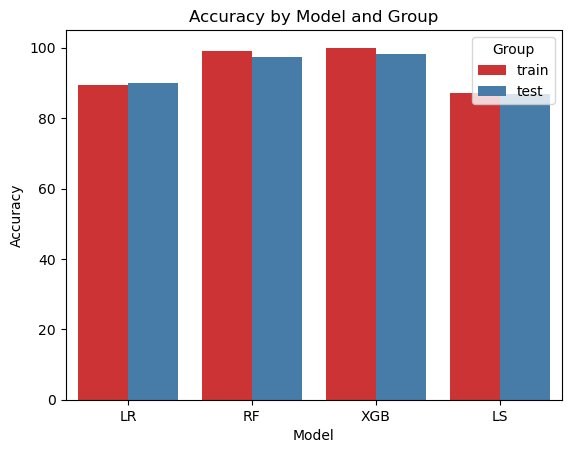

In [36]:
custom_palette = sns.color_palette("Set1")
sns.barplot(
    x='Model',
    y='Accuracy2',
    hue='Group',
    data=models,
    palette=custom_palette
)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model and Group')
plt.show()

  ## <a id="61" style="color: darkred;"> Predictions on new data: </a>

In [37]:
new_data = pd.DataFrame({'TV': [25], 'Radio': [63], 'Newspaper': [80]})
predicted_sales = rf.predict(new_data)
print("Predicted Sales:", predicted_sales)

Predicted Sales: [25.02047333]
